In [1]:
!py -m pip install -q opencv-python pillow matplotlib numpy


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!py -m pip install -q paddleocr

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import re
import json
import math
from dataclasses import dataclass
from datetime import datetime
from typing import List, Dict, Any, Optional, Tuple

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def show(img, title=None, cmap=None, figsize=(8,5)):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

def to_bgr(pil_img: Image.Image) -> np.ndarray:
    arr = np.array(pil_img)
    if arr.ndim == 2:
        return cv2.cvtColor(arr, cv2.COLOR_GRAY2BGR)
    return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)

def safe_float(x, default=0.0):
    try:
        return float(x)
    except Exception:
        return default


In [11]:
import os
os.environ["DISABLE_MODEL_SOURCE_CHECK"] = "True"  # optional

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # hides that warning

from paddleocr import PaddleOCR

# Create ONE global model (no repeated "Creating model..." every call)
PADDLE_OCR = PaddleOCR(use_textline_orientation=True, lang="en")
print("✅ PaddleOCR initialized once.")


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish

✅ PaddleOCR initialized once.


Loaded: IMG_20251212_152936.jpg
Size: (720, 480) Mode: RGB


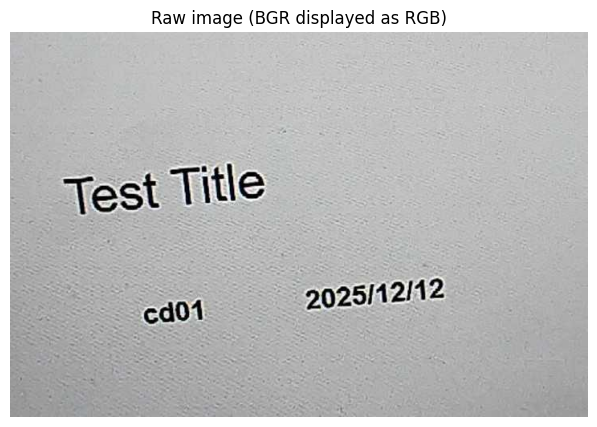

In [3]:
IMAGE_PATH = "IMG_20251212_152936.jpg"  # put your path here

pil = Image.open(IMAGE_PATH)
bgr = to_bgr(pil)

print("Loaded:", IMAGE_PATH)
print("Size:", pil.size, "Mode:", pil.mode)

show(bgr, "Raw image (BGR displayed as RGB)")


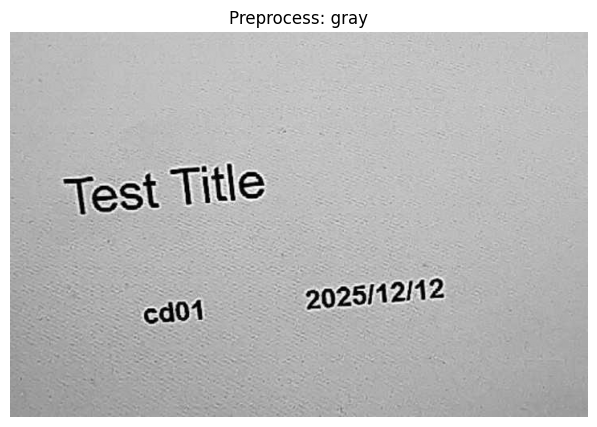

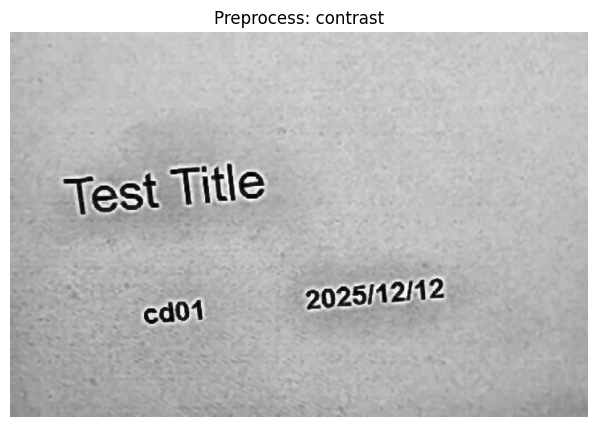

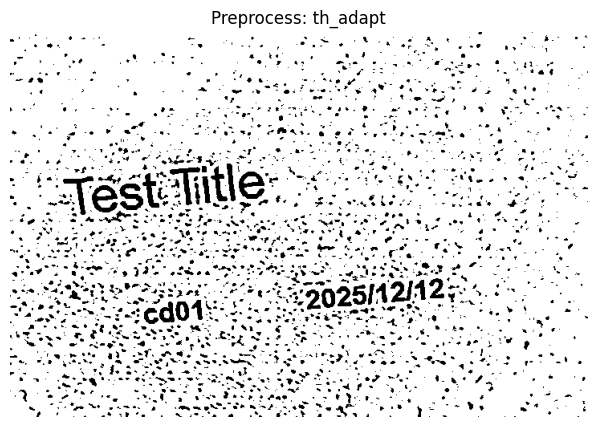

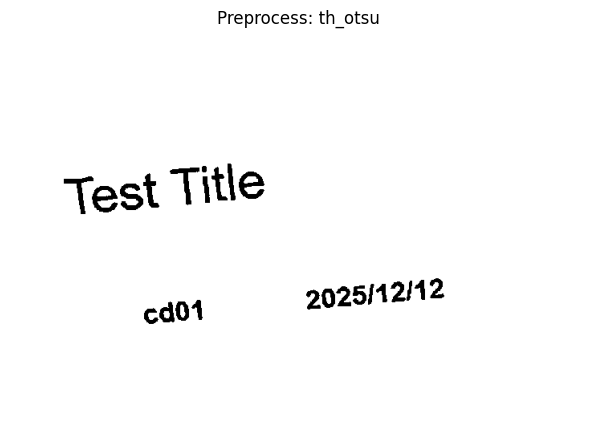

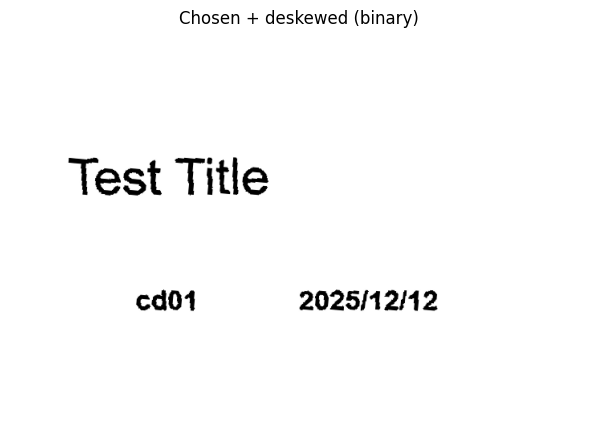

In [4]:
def preprocess_variants(bgr: np.ndarray) -> Dict[str, np.ndarray]:
    """Return multiple preprocessed images to compare."""
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # Mild denoise
    den = cv2.bilateralFilter(gray, d=7, sigmaColor=50, sigmaSpace=50)

    # Contrast boost (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    con = clahe.apply(den)

    # Adaptive threshold (good for uneven lighting)
    th_adapt = cv2.adaptiveThreshold(
        con, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 7
    )

    # Otsu threshold (sometimes works great for clean scans)
    _, th_otsu = cv2.threshold(con, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return {
        "gray": gray,
        "contrast": con,
        "th_adapt": th_adapt,
        "th_otsu": th_otsu,
    }

def deskew(binary_img: np.ndarray) -> np.ndarray:
    """
    Deskew a binary image (white background, dark text).
    Returns rotated binary. Safe if it can't detect angle.
    """
    # Invert so text is white on black for easier nonzero extraction
    inv = 255 - binary_img
    coords = np.column_stack(np.where(inv > 0))
    if len(coords) < 50:
        return binary_img  # too little text to estimate

    rect = cv2.minAreaRect(coords)
    angle = rect[-1]
    # minAreaRect angle quirks:
    # angle in [-90, 0); convert to a more intuitive rotation
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = binary_img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    rotated = cv2.warpAffine(binary_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

variants = preprocess_variants(bgr)

for k, img in variants.items():
    show(img, f"Preprocess: {k}")

# Pick one thresholding result for OCR:
chosen = variants["th_otsu"]  # try th_otsu if better
deskewed = deskew(chosen)

show(deskewed, "Chosen + deskewed (binary)")


In [6]:

@dataclass
class OCRLine:
    text: str
    conf: float  # 0..1
    box: Optional[List[List[float]]] = None  # optional quadrilateral

def ocr_with_paddle(binary_or_gray: np.ndarray) -> List[OCRLine]:
    from paddleocr import PaddleOCR
    import os
    os.environ["DISABLE_MODEL_SOURCE_CHECK"] = "True"


    # PaddleOCR expects RGB or BGR image; it can handle grayscale too
    # If binary, convert to 3-channel:
    img = binary_or_gray
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    ocr = PaddleOCR(use_textline_orientation=True, lang="en")  # you can change lang later
    res = ocr.ocr(img, cls=True)

    lines: List[OCRLine] = []
    # res structure: [[ [box, (text, conf)], ... ]]
    for block in res:
        for item in block:
            box = item[0]
            text, conf = item[1]
            lines.append(OCRLine(text=text.strip(), conf=float(conf), box=box))
    return lines

def ocr_with_tesseract(binary_or_gray: np.ndarray) -> List[OCRLine]:
    import pytesseract

    img = binary_or_gray
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Get word-level data, then group into lines
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    n = len(data["text"])
    rows = []
    for i in range(n):
        text = (data["text"][i] or "").strip()
        conf = safe_float(data["conf"][i], -1.0)
        if conf < 0 or text == "":
            continue
        rows.append({
            "block": data["block_num"][i],
            "par": data["par_num"][i],
            "line": data["line_num"][i],
            "word": data["word_num"][i],
            "text": text,
            "conf": conf / 100.0
        })

    # Group by (block, par, line)
    grouped: Dict[Tuple[int,int,int], List[Dict[str,Any]]] = {}
    for r in rows:
        key = (r["block"], r["par"], r["line"])
        grouped.setdefault(key, []).append(r)

    lines: List[OCRLine] = []
    for key, words in grouped.items():
        words = sorted(words, key=lambda x: x["word"])
        line_text = " ".join(w["text"] for w in words).strip()
        line_conf = float(np.mean([w["conf"] for w in words])) if words else 0.0
        lines.append(OCRLine(text=line_text, conf=line_conf, box=None))

    return lines

def run_ocr(img_for_ocr: np.ndarray) -> Tuple[str, List[OCRLine]]:
    # Prefer PaddleOCR if installed
    try:
        lines = ocr_with_paddle(img_for_ocr)
        return "paddleocr", lines
    except Exception as e_paddle:
        print("PaddleOCR not available or failed, falling back to Tesseract.")
        print("PaddleOCR error:", repr(e_paddle))
        lines = ocr_with_tesseract(img_for_ocr)
        return "tesseract", lines

# engine, ocr_lines = run_ocr(deskewed)
# print("OCR engine:", engine)
# print("OCR lines:")
# for i, ln in enumerate(ocr_lines, 1):
#     print(f"{i:02d}. conf={ln.conf:.2f}  text={ln.text}")


In [12]:
import os
os.environ["DISABLE_MODEL_SOURCE_CHECK"] = "True"  # avoids that connectivity check

from typing import List, Tuple
import cv2
import numpy as np

# Reuse your OCRLine dataclass from earlier
# @dataclass
# class OCRLine:
#     text: str
#     conf: float
#     box: Optional[List[List[float]]] = None

import cv2
import numpy as np
import inspect
from typing import List

def ocr_with_paddle_robust(img_in: np.ndarray) -> List[OCRLine]:
    """
    Uses global PADDLE_OCR and prefers .predict() if available.
    Returns list of OCRLine(text, conf, box).
    """
    img = img_in
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    ocr = PADDLE_OCR
    lines: List[OCRLine] = []

    # 1) Prefer predict() (new API)
    if hasattr(ocr, "predict"):
        try:
            res = ocr.predict(img)

            parsed = []
            if isinstance(res, dict):
                parsed = [res]
            elif isinstance(res, list):
                parsed = res

            # common dict format: rec_texts / rec_scores, dt_polys
            for r in parsed:
                if isinstance(r, dict):
                    texts = r.get("rec_texts") or r.get("texts") or []
                    scores = r.get("rec_scores") or r.get("scores") or []
                    boxes  = r.get("dt_polys") or r.get("boxes") or [None]*len(texts)
                    for t, s, b in zip(texts, scores, boxes):
                        lines.append(OCRLine(text=str(t).strip(), conf=float(s), box=b))

            if lines:
                return lines
        except Exception:
            pass  # fallback to ocr()

    # 2) Fallback: ocr() (older API)
    if hasattr(ocr, "ocr"):
        sig = inspect.signature(ocr.ocr)
        if "cls" in sig.parameters:
            res = ocr.ocr(img, cls=True)
        else:
            res = ocr.ocr(img)

        for block in res:
            for item in block:
                box = item[0]
                text, conf = item[1]
                lines.append(OCRLine(text=str(text).strip(), conf=float(conf), box=box))
        return lines

    raise RuntimeError("Neither predict() nor ocr() is available on PaddleOCR object.")


def run_ocr(img_for_ocr: np.ndarray) -> Tuple[str, List[OCRLine]]:
    try:
        lines = ocr_with_paddle_robust(img_for_ocr)
        return "paddleocr", lines
    except Exception as e_paddle:
        print("PaddleOCR failed, falling back to Tesseract.")
        print("PaddleOCR error:", repr(e_paddle))
        lines = ocr_with_tesseract(img_for_ocr)
        return "tesseract", lines


engine, ocr_lines = run_ocr(deskewed)

print("OCR engine:", engine)
print("OCR lines:")
for i, ln in enumerate(ocr_lines, 1):
    print(f"{i:02d}. conf={ln.conf:.2f}  text={ln.text}")


OCR engine: paddleocr
OCR lines:
01. conf=1.00  text=Test Title
02. conf=1.00  text=cd01
03. conf=1.00  text=2025/12/12


In [16]:
import re
import json
from datetime import datetime
from typing import Optional, List, Dict, Any

DATE_RE = re.compile(r"\b(\d{4}[\/\-.]\d{1,2}[\/\-.]\d{1,2})\b")

def parse_date_to_iso(s: str) -> Optional[str]:
    s2 = s.replace(".", "/").replace("-", "/")
    for fmt in ("%Y/%m/%d",):
        try:
            dt = datetime.strptime(s2, fmt)
            return dt.strftime("%Y-%m-%d")
        except ValueError:
            pass
    return None

def score_code_candidate(tok: str) -> float:
    t = tok.strip()
    if len(t) < 2 or len(t) > 25:
        return -999.0
    if DATE_RE.search(t):
        return -999.0

    # mostly alnum and a few separators
    allowed = sum(ch.isalnum() or ch in "-_/" for ch in t)
    ratio = allowed / max(1, len(t))
    if ratio < 0.85:
        return -5.0

    score = 0.0
    if re.fullmatch(r"[A-Za-z]{1,6}\d{1,6}", t):  # cd01, A1239
        score += 4.0
    if re.fullmatch(r"[A-Za-z0-9]+[-_][A-Za-z0-9]+", t):
        score += 2.0
    if any(ch.isdigit() for ch in t):
        score += 1.0
    if any(ch.isalpha() for ch in t):
        score += 1.0
    if " " in t:
        score -= 2.0

    return score + ratio

def score_title_candidate(text: str) -> float:
    t = text.strip()
    if len(t) < 3:
        return -999.0
    if DATE_RE.search(t):
        return -999.0

    letters = sum(ch.isalpha() for ch in t)
    digits = sum(ch.isdigit() for ch in t)
    spaces = sum(ch.isspace() for ch in t)
    alpha_ratio = letters / max(1, len(t))

    score = 0.0
    score += alpha_ratio * 5.0
    score += min(len(t) / 10.0, 3.0)
    score -= digits * 0.3
    score += 0.5 if spaces >= 1 else 0.0
    return score

def extract_fields_from_lines(ocr_lines) -> Dict[str, Any]:
    # Expect ocr_lines like: [{'text':..., 'conf':...}] or OCRLine objects
    # Normalize to dicts
    norm = []
    for ln in ocr_lines:
        text = getattr(ln, "text", None) if not isinstance(ln, dict) else ln.get("text")
        conf = getattr(ln, "conf", None) if not isinstance(ln, dict) else ln.get("conf")
        if text is None:
            continue
        text = text.strip()
        if not text:
            continue
        conf = float(conf) if conf is not None else 0.0
        norm.append({"text": text, "conf": conf})

    debug = {"date_candidates": [], "code_candidates": [], "title_candidates": []}

    # --- DATE: search anywhere, even if line has other stuff ---
    date_best = None
    date_best_score = -1e9
    for ln in norm:
        for m in DATE_RE.finditer(ln["text"]):
            raw = m.group(1)
            iso = parse_date_to_iso(raw)
            if not iso:
                continue
            score = 10.0 + ln["conf"]
            debug["date_candidates"].append({"raw": raw, "iso": iso, "line": ln["text"], "conf": ln["conf"], "score": score})
            if score > date_best_score:
                date_best_score = score
                date_best = {"raw": raw, "iso": iso, "conf": ln["conf"], "line_text": ln["text"]}

    # --- CODE: consider tokens AND line-with-date-removed ---
    code_best = None
    code_best_score = -1e9
    for ln in norm:
        line = ln["text"]

        # remove date substrings from line to isolate code candidates
        line_wo_date = DATE_RE.sub(" ", line).strip()

        # token candidates from original and date-removed line
        tokens = re.split(r"\s+", line_wo_date)
        tokens = [t.strip(" ,;:()[]{}") for t in tokens if t.strip(" ,;:()[]{}")]

        # also consider the whole date-removed line if it's short
        if 0 < len(line_wo_date) <= 25:
            tokens.append(line_wo_date)

        for cand in tokens:
            sc = score_code_candidate(cand)
            score = sc + ln["conf"]
            debug["code_candidates"].append({"candidate": cand, "from_line": line, "conf": ln["conf"], "score": score})
            if score > code_best_score:
                code_best_score = score
                code_best = {"value": cand, "conf": ln["conf"], "line_text": line}

    # --- TITLE: best remaining line (excluding the line that is mainly code/date if needed) ---
    exclude_lines = set()
    if date_best:
        exclude_lines.add(date_best["line_text"])
    # NOTE: we do NOT exclude code line always, because code+date could be on same line
    # We'll just rank titles; "Test Title" will win anyway.

    title_best = None
    title_best_score = -1e9
    for ln in norm:
        if ln["text"] in exclude_lines and len(norm) > 1:
            continue
        sc = score_title_candidate(ln["text"])
        score = sc + ln["conf"]
        debug["title_candidates"].append({"candidate": ln["text"], "conf": ln["conf"], "score": score})
        if score > title_best_score:
            title_best_score = score
            title_best = {"value": ln["text"], "conf": ln["conf"], "line_text": ln["text"]}

    errors = []
    if not title_best: errors.append("title not found")
    if not date_best: errors.append("date not found")
    if not code_best: errors.append("code not found")

    if errors:
        return {
            "status": "failed",
            "error": "Unable to extract required fields: " + ", ".join(errors),
            "debug": debug,
            "raw_lines": norm,
        }

    return {
        "status": "success",
        "title": title_best["value"],
        "date": date_best["iso"],
        "code": code_best["value"],
        "confidence": {"title": title_best["conf"], "date": date_best["conf"], "code": code_best["conf"]},
        "debug": debug,
        "raw_lines": norm,
    }

# Run extraction using your existing "ocr_lines" variable (from Step 4)
result = extract_fields_from_lines(ocr_lines)
print(json.dumps(result, indent=2, ensure_ascii=False))


{
  "status": "success",
  "title": "Test Title",
  "date": "2025-12-12",
  "code": "cd01",
  "confidence": {
    "title": 0.9998038411140442,
    "date": 0.9999787211418152,
    "code": 0.997607946395874
  },
  "debug": {
    "date_candidates": [
      {
        "raw": "2025/12/12",
        "iso": "2025-12-12",
        "line": "2025/12/12",
        "conf": 0.9999787211418152,
        "score": 10.999978721141815
      }
    ],
    "code_candidates": [
      {
        "candidate": "Test",
        "from_line": "Test Title",
        "conf": 0.9998038411140442,
        "score": 2.999803841114044
      },
      {
        "candidate": "Title",
        "from_line": "Test Title",
        "conf": 0.9998038411140442,
        "score": 2.999803841114044
      },
      {
        "candidate": "Test Title",
        "from_line": "Test Title",
        "conf": 0.9998038411140442,
        "score": 0.8998038411140442
      },
      {
        "candidate": "cd01",
        "from_line": "cd01",
        "conf"

In [ ]:
# import re
# import json
# from datetime import datetime
# from typing import Optional, Dict, Any, List

# DATE_RE = re.compile(r"\b(\d{4}[\/\-.]\d{1,2}[\/\-.]\d{1,2})\b")

# def parse_date_to_iso(s: str) -> Optional[str]:
#     s2 = s.replace(".", "/").replace("-", "/")
#     try:
#         dt = datetime.strptime(s2, "%Y/%m/%d")
#         return dt.strftime("%Y-%m-%d")
#     except ValueError:
#         return None

# def score_code_candidate(tok: str) -> float:
#     t = tok.strip()
#     if len(t) < 2 or len(t) > 25:
#         return -999.0
#     if DATE_RE.search(t):
#         return -999.0

#     allowed = sum(ch.isalnum() or ch in "-_/" for ch in t)
#     ratio = allowed / max(1, len(t))
#     if ratio < 0.85:
#         return -5.0

#     score = 0.0
#     if re.fullmatch(r"[A-Za-z]{1,6}\d{1,6}", t):  # cd01, A1239
#         score += 4.0
#     if re.fullmatch(r"[A-Za-z0-9]+[-_][A-Za-z0-9]+", t):  # INV-204
#         score += 2.0
#     if any(ch.isdigit() for ch in t):
#         score += 1.0
#     if any(ch.isalpha() for ch in t):
#         score += 1.0
#     if " " in t:
#         score -= 2.0

#     return score + ratio

# def score_title_candidate(text: str) -> float:
#     t = text.strip()
#     if len(t) < 3:
#         return -999.0
#     if DATE_RE.search(t):
#         return -999.0

#     letters = sum(ch.isalpha() for ch in t)
#     digits = sum(ch.isdigit() for ch in t)
#     spaces = sum(ch.isspace() for ch in t)
#     alpha_ratio = letters / max(1, len(t))

#     score = 0.0
#     score += alpha_ratio * 5.0
#     score += min(len(t) / 10.0, 3.0)     # length bonus (cap)
#     score -= digits * 0.3                # penalize digits
#     score += 0.5 if spaces >= 1 else 0.0 # multi-word bonus
#     return score

# def extract_fields(ocr_lines) -> Dict[str, Any]:
#     # Normalize lines into dicts
#     lines = []
#     for ln in ocr_lines:
#         text = getattr(ln, "text", None) if not isinstance(ln, dict) else ln.get("text")
#         conf = getattr(ln, "conf", None) if not isinstance(ln, dict) else ln.get("conf")
#         if not text:
#             continue
#         text = text.strip()
#         if not text:
#             continue
#         lines.append({"text": text, "conf": float(conf) if conf is not None else 0.0})

#     debug = {"date_candidates": [], "code_candidates": [], "title_candidates": []}

#     # --- DATE ---
#     date_best = None
#     date_best_score = -1e9
#     for ln in lines:
#         for m in DATE_RE.finditer(ln["text"]):
#             raw = m.group(1)
#             iso = parse_date_to_iso(raw)
#             if not iso:
#                 continue
#             score = 10.0 + ln["conf"]
#             debug["date_candidates"].append({"raw": raw, "iso": iso, "line": ln["text"], "conf": ln["conf"], "score": score})
#             if score > date_best_score:
#                 date_best_score = score
#                 date_best = {"raw": raw, "iso": iso, "conf": ln["conf"], "line_text": ln["text"]}

#     # --- CODE ---
#     code_best = None
#     code_best_score = -1e9
#     for ln in lines:
#         t = ln["text"].strip()
#         sc = score_code_candidate(t)
#         score = sc + ln["conf"]
#         debug["code_candidates"].append({"candidate": t, "conf": ln["conf"], "score": score})
#         if score > code_best_score:
#             code_best_score = score
#             code_best = {"value": t, "conf": ln["conf"], "line_text": ln["text"]}

#     # --- TITLE ---
#     exclude = set()
#     if date_best:
#         exclude.add(date_best["line_text"])
#     if code_best:
#         exclude.add(code_best["line_text"])

#     title_best = None
#     title_best_score = -1e9
#     for ln in lines:
#         t = ln["text"].strip()
#         if t in exclude and len(lines) > 1:
#             continue
#         sc = score_title_candidate(t)
#         score = sc + ln["conf"]
#         debug["title_candidates"].append({"candidate": t, "conf": ln["conf"], "score": score})
#         if score > title_best_score:
#             title_best_score = score
#             title_best = {"value": t, "conf": ln["conf"], "line_text": ln["text"]}

#     errors = []
#     if not title_best: errors.append("title not found")
#     if not date_best: errors.append("date not found")
#     if not code_best: errors.append("code not found")

#     if errors:
#         return {
#             "status": "failed",
#             "error": "Unable to extract required fields: " + ", ".join(errors),
#             "debug": debug,
#             "raw_lines": lines
#         }

#     return {
#         "status": "success",
#         "title": title_best["value"],
#         "date": date_best["iso"],
#         "code": code_best["value"],
#         "confidence": {
#             "title": title_best["conf"],
#             "date": date_best["conf"],
#             "code": code_best["conf"]
#         },
#         "debug": debug,
#         "raw_lines": lines
#     }

# result = extract_fields(ocr_lines)
# print(json.dumps(result, indent=2, ensure_ascii=False))


{
  "status": "success",
  "title": "Test Title",
  "date": "2025-12-12",
  "code": "cd01",
  "confidence": {
    "title": 0.9998038411140442,
    "date": 0.9999787211418152,
    "code": 0.997607946395874
  },
  "debug": {
    "date_candidates": [
      {
        "raw": "2025/12/12",
        "iso": "2025-12-12",
        "line": "2025/12/12",
        "conf": 0.9999787211418152,
        "score": 10.999978721141815
      }
    ],
    "code_candidates": [
      {
        "candidate": "Test Title",
        "conf": 0.9998038411140442,
        "score": 0.8998038411140442
      },
      {
        "candidate": "cd01",
        "conf": 0.997607946395874,
        "score": 7.997607946395874
      },
      {
        "candidate": "2025/12/12",
        "conf": 0.9999787211418152,
        "score": -998.0000212788582
      }
    ],
    "title_candidates": [
      {
        "candidate": "Test Title",
        "conf": 0.9998038411140442,
        "score": 6.999803841114044
      }
    ]
  },
  "raw_lines": 

In [9]:
import cv2
import numpy as np
from PIL import Image
from typing import Dict, Any, Tuple, List

# ---------- helpers (from earlier) ----------
def to_bgr(pil_img: Image.Image) -> np.ndarray:
    arr = np.array(pil_img)
    if arr.ndim == 2:
        return cv2.cvtColor(arr, cv2.COLOR_GRAY2BGR)
    return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)

def preprocess_variants(bgr: np.ndarray) -> Dict[str, np.ndarray]:
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    den = cv2.bilateralFilter(gray, d=7, sigmaColor=50, sigmaSpace=50)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    con = clahe.apply(den)
    th_adapt = cv2.adaptiveThreshold(
        con, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 7
    )
    _, th_otsu = cv2.threshold(con, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return {"gray": gray, "contrast": con, "th_adapt": th_adapt, "th_otsu": th_otsu}

def deskew(binary_img: np.ndarray) -> np.ndarray:
    inv = 255 - binary_img
    coords = np.column_stack(np.where(inv > 0))
    if len(coords) < 50:
        return binary_img
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = binary_img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    rotated = cv2.warpAffine(binary_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def ocr_lines_to_text(lines) -> str:
    return "\n".join([ln.text for ln in lines if getattr(ln, "text", "").strip()])

# ---------- YOUR: ocr_with_paddle_robust + run_ocr ----------
# Make sure you already ran the cell where these are defined:
# - OCRLine dataclass
# - ocr_with_paddle_robust(...)
# - run_ocr(...)
# - extract_fields(...)

def process_image(image_path: str, preprocess_choice: str = "th_adapt") -> Dict[str, Any]:
    """
    End-to-end: load -> preprocess -> OCR -> extract -> return JSON
    preprocess_choice: 'th_adapt' or 'th_otsu'
    """
    # 1) load
    pil = Image.open(image_path)
    bgr = to_bgr(pil)

    # 2) preprocess
    vars_ = preprocess_variants(bgr)
    if preprocess_choice not in vars_:
        preprocess_choice = "th_adapt"
    chosen = vars_[preprocess_choice]
    chosen = deskew(chosen)

    # 3) OCR
    engine, ocr_lines = run_ocr(chosen)

    # 4) extract
    result = extract_fields(ocr_lines)

    # 5) attach useful debug artifacts for DB later
    result["ocr_engine"] = engine
    result["raw_text"] = ocr_lines_to_text(ocr_lines)
    result["raw_lines"] = [{"text": ln.text, "conf": float(ln.conf)} for ln in ocr_lines]

    return result

# --- test it ---
IMAGE_PATH = "IMG_20251212_152936.jpg"  # change to your path
out = process_image(IMAGE_PATH, preprocess_choice="th_adapt")
print(json.dumps(out, indent=2, ensure_ascii=False))


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish

{
  "status": "success",
  "title": "Test Title",
  "date": "2025-12-12",
  "code": "Cd01",
  "confidence": {
    "title": 0.9559680819511414,
    "date": 0.9956592321395874,
    "code": 0.8817858695983887
  },
  "debug": {
    "date_candidates": [
      {
        "raw": "2025/12/12",
        "iso": "2025-12-12",
        "line": "2025/12/12",
        "conf": 0.9956592321395874,
        "score": 10.995659232139587
      }
    ],
    "code_candidates": [
      {
        "candidate": "Test Title",
        "conf": 0.9559680819511414,
        "score": 0.8559680819511414
      },
      {
        "candidate": "2025/12/12",
        "conf": 0.9956592321395874,
        "score": -998.0043407678604
      },
      {
        "candidate": "Cd01",
        "conf": 0.8817858695983887,
        "score": 7.881785869598389
      }
    ],
    "title_candidates": [
      {
        "candidate": "Test Title",
        "conf": 0.9559680819511414,
        "score": 6.955968081951141
      }
    ]
  },
  "raw_lines"

In [10]:
IMAGE_PATH = "IMG_20251212_152936.jpg"  # change to your path
out = process_image(IMAGE_PATH, preprocess_choice="th_otsu")
print(json.dumps(out, indent=2, ensure_ascii=False))

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish

{
  "status": "success",
  "title": "Test Title",
  "date": "2025-12-12",
  "code": "cd01",
  "confidence": {
    "title": 0.9998038411140442,
    "date": 0.9999787211418152,
    "code": 0.997607946395874
  },
  "debug": {
    "date_candidates": [
      {
        "raw": "2025/12/12",
        "iso": "2025-12-12",
        "line": "2025/12/12",
        "conf": 0.9999787211418152,
        "score": 10.999978721141815
      }
    ],
    "code_candidates": [
      {
        "candidate": "Test Title",
        "conf": 0.9998038411140442,
        "score": 0.8998038411140442
      },
      {
        "candidate": "cd01",
        "conf": 0.997607946395874,
        "score": 7.997607946395874
      },
      {
        "candidate": "2025/12/12",
        "conf": 0.9999787211418152,
        "score": -998.0000212788582
      }
    ],
    "title_candidates": [
      {
        "candidate": "Test Title",
        "conf": 0.9998038411140442,
        "score": 6.999803841114044
      }
    ]
  },
  "raw_lines": 

In [28]:
import cv2
import numpy as np
from typing import List

def run_paddle_ocr_safe(img_in: np.ndarray) -> List[OCRLine]:
    """
    Uses global PADDLE_OCR.
    Returns OCRLine list or empty list (never throws parsing errors).
    """
    img = img_in
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # ensure uint8
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    ocr = PADDLE_OCR
    lines: List[OCRLine] = []

    # Prefer predict() if available
    if hasattr(ocr, "predict"):
        try:
            res = ocr.predict(img)
            parsed = res if isinstance(res, list) else [res]

            for r in parsed:
                if not isinstance(r, dict):
                    continue
                texts = r.get("rec_texts") or r.get("texts") or []
                scores = r.get("rec_scores") or r.get("scores") or []
                boxes  = r.get("dt_polys") or r.get("boxes") or [None]*len(texts)

                # make lengths consistent
                if len(scores) != len(texts):
                    scores = list(scores) + [1.0] * (len(texts) - len(scores))

                for t, s, b in zip(texts, scores, boxes):
                    t = str(t).strip()
                    if t:
                        lines.append(OCRLine(text=t, conf=float(s), box=b))
            return lines
        except Exception:
            pass  # fallback to ocr()

    # Fallback old .ocr()
    if hasattr(ocr, "ocr"):
        try:
            res = ocr.ocr(img)
            # expected: [[ [box, (text, conf)], ... ]]
            for block in res or []:
                for item in block or []:
                    if not (isinstance(item, (list, tuple)) and len(item) >= 2):
                        continue
                    box = item[0]
                    tconf = item[1]
                    # SAFE: ensure (text, conf)
                    if isinstance(tconf, (list, tuple)) and len(tconf) >= 2:
                        text, conf = tconf[0], tconf[1]
                    else:
                        continue
                    text = str(text).strip()
                    if text:
                        lines.append(OCRLine(text=text, conf=float(conf), box=box))
            return lines
        except Exception:
            return []

    return []


In [29]:
import numpy as np
import cv2
from PIL import Image

def resize_max_side(bgr: np.ndarray, max_side: int = 1100) -> np.ndarray:
    h, w = bgr.shape[:2]
    m = max(h, w)
    if m <= max_side:
        return bgr
    scale = max_side / m
    new_w, new_h = int(w * scale), int(h * scale)
    return cv2.resize(bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)

def rotate_image(bgr: np.ndarray, angle_deg: float) -> np.ndarray:
    h, w = bgr.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle_deg, 1.0)
    return cv2.warpAffine(bgr, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

def estimate_skew_angle_from_binary(binary_img: np.ndarray) -> float:
    inv = 255 - binary_img
    coords = np.column_stack(np.where(inv > 0))
    if len(coords) < 50:
        return 0.0
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    return float(angle)

def avg_conf(res: dict) -> float:
    c = res.get("confidence", {}) or {}
    return (c.get("title", 0) + c.get("code", 0) + c.get("date", 0)) / 3.0

def process_image_fast(
    image_path: str,
    max_side: int = 1100,
    conf_stop: float = 0.97,
    try_contrast: bool = True,
    try_th_adapt: bool = True,
    try_th_otsu: bool = False,   # default OFF because it caused issues + slower
) -> dict:
    pil = Image.open(image_path)
    bgr = to_bgr(pil)
    bgr = resize_max_side(bgr, max_side=max_side)

    # preprocess just enough to estimate skew
    vars_ = preprocess_variants(bgr)
    angle = estimate_skew_angle_from_binary(vars_["th_adapt"])
    bgr_rot = rotate_image(bgr, angle)

    # Candidate variants in order
    candidates = [("orig_rot", bgr_rot)]

    if try_contrast:
        candidates.append(("contrast", cv2.cvtColor(vars_["contrast"], cv2.COLOR_GRAY2BGR)))
    if try_th_adapt:
        candidates.append(("th_adapt", cv2.cvtColor(deskew(vars_["th_adapt"]), cv2.COLOR_GRAY2BGR)))
    if try_th_otsu:
        candidates.append(("th_otsu", cv2.cvtColor(deskew(vars_["th_otsu"]), cv2.COLOR_GRAY2BGR)))

    best = None
    best_score = -1e9

    for name, img in candidates:
        lines = run_paddle_ocr_safe(img)  # Paddle only (fast, no tesseract)
        res = extract_fields_v2(lines)

        # scoring
        if res["status"] == "success":
            score = 100.0 + avg_conf(res) + len(lines) * 0.02
        else:
            score = len(lines) * 0.01

        if score > best_score:
            best_score = score
            best = res
            best["ocr_engine"] = "paddleocr"
            best["variant_used"] = name
            best["raw_text"] = "\n".join([ln.text for ln in lines if ln.text.strip()])
            best["raw_lines"] = [{"text": ln.text, "conf": float(ln.conf)} for ln in lines]

        # ✅ EARLY EXIT: if good enough, stop trying more variants
        if res["status"] == "success" and avg_conf(res) >= conf_stop:
            break

    return best


In [32]:
import os
import pandas as pd

SAMPLES_DIR = "./samples"  

rows = []
for fn in sorted(os.listdir(SAMPLES_DIR)):
    if not fn.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
        continue
    path = os.path.join(SAMPLES_DIR, fn)
    out = process_image_fast(path, max_side=1100, conf_stop=0.97, try_th_otsu=False)


    rows.append({
        "file": fn,
        "status": out.get("status"),
        "title": out.get("title"),
        "date": out.get("date"),
        "code": out.get("code"),
        "ocr_engine": out.get("ocr_engine"),
        "conf_title": out.get("confidence", {}).get("title"),
        "conf_date": out.get("confidence", {}).get("date"),
        "conf_code": out.get("confidence", {}).get("code"),
        "error": out.get("error"),
    })

df = pd.DataFrame(rows)
display(df)

df.to_csv("batch_results.csv", index=False)
print("✅ Saved: batch_results.csv")


,file,status,title,date,code,ocr_engine,conf_title,conf_date,conf_code,error
0,sample_001.jpg,success,Note Medication 54,2023-04-16,bt63,paddleocr,0.986661,0.999943,0.999451,None
1,sample_002.jpg,failed,None,None,None,paddleocr,NaN,NaN,NaN,Unable to extract required fields: date not found
2,sample_003.jpg,success,Patient Result Capsule Prescription Pharmacy C...,2023-11-18,LOT-39U,paddleocr,0.973404,0.991234,0.973404,None
3,sample_004.jpg,success,Tablet Clinical Report Capsule,2023-03-06,yb96,paddleocr,0.992960,0.998862,0.998862,None
4,sample_005.jpg,success,er Result Tablet Label Delivery 253,2023-12-02,LOT-70E,paddleocr,0.970968,0.993358,0.993358,None
5,sample_006.jpg,success,Identifier:,2025-01-23,422,paddleocr,0.967069,0.946496,0.999916,None
6,sample_007.jpg,success,Report Medication Capsule,2024-07-01,507,paddleocr,0.985807,0.994934,0.985892,None
7,sample_008.jpg,success,Note Pharmacy Result 51,2023-04-25,fy2,paddleocr,0.965267,0.999953,0.999959,None
8,sample_009.jpg,success,Result Order,2023-11-11,INV-5219,paddleocr,0.992819,0.999959,0.952593,None
9,sample_010.jpg,success,Prescription Pharmacy Tablet,2023-01-08,9066,paddleocr,0.999536,0.999750,0.971333,None


✅ Saved: batch_results.csv


In [23]:
import re
import json
from datetime import datetime
from typing import Optional, Dict, Any, List

DATE_RE = re.compile(r"\b(\d{4}[\/\-.]\d{1,2}[\/\-.]\d{1,2})\b", re.I)
LABEL_RE = re.compile(r"^\s*(code|id|identifier)\s*[:\-]\s*", re.I)

# Code token patterns (expand later if your real codes differ)
CODE_PATTERNS = [
    re.compile(r"\b[A-Za-z]{1,6}\d{1,6}\b"),              # cd01, A1239
    re.compile(r"\b(?:INV|RX|LOT)[\-_]?[A-Za-z0-9]+\b", re.I),  # INV-123, RX_9999, LOT-17P
    re.compile(r"\b[A-Za-z0-9]+[-_][A-Za-z0-9]+\b"),      # AA-12, RX_1234
    re.compile(r"\b[A-Za-z]{1,3}\d{1,4}\b"),              # w35, od04
]

def parse_date_to_iso(s: str) -> Optional[str]:
    s2 = s.replace(".", "/").replace("-", "/")
    try:
        dt = datetime.strptime(s2, "%Y/%m/%d")
        return dt.strftime("%Y-%m-%d")
    except ValueError:
        return None

def bbox_height(box) -> float:
    """box is 4 points [[x,y]..] or None"""
    if box is None:
        return 0.0
    ys = [p[1] for p in box if len(p) >= 2]
    return float(max(ys) - min(ys)) if ys else 0.0

def normalize_line_for_code(line: str) -> str:
    s = line.strip()
    s = LABEL_RE.sub("", s)           # remove "Code:" / "Identifier:" / "ID:"
    s = DATE_RE.sub(" ", s)           # remove date fragments
    s = re.sub(r"[,\;\(\)\[\]\{\}]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def code_token_candidates(line: str) -> List[str]:
    s = normalize_line_for_code(line)
    cands = set()

    # regex-based tokens
    for pat in CODE_PATTERNS:
        for m in pat.finditer(s):
            cands.add(m.group(0).strip())

    # token split fallback (only tokens that contain at least one digit)
    for tok in re.split(r"\s+", s):
        tok = tok.strip().strip(":.-_")
        if tok and any(ch.isdigit() for ch in tok):
            cands.add(tok)

    return list(cands)

def score_code_token(tok: str) -> float:
    t = tok.strip()
    if len(t) < 2 or len(t) > 25:
        return -999.0
    if DATE_RE.search(t):
        return -999.0

    # must contain at least one digit to avoid picking words like "Packaging"
    if not any(ch.isdigit() for ch in t):
        return -50.0

    # mostly alnum/separators
    allowed = sum(ch.isalnum() or ch in "-_/" for ch in t)
    ratio = allowed / max(1, len(t))
    if ratio < 0.80:
        return -10.0

    score = 0.0
    if re.fullmatch(r"[A-Za-z]{1,6}\d{1,6}", t):
        score += 5.0
    if re.fullmatch(r"[A-Za-z0-9]+[-_][A-Za-z0-9]+", t):
        score += 3.0
    if re.match(r"^(INV|RX|LOT)", t, re.I):
        score += 2.0

    return score + ratio

def looks_like_code(line: str) -> bool:
    return len(code_token_candidates(line)) > 0

def extract_fields_v2(ocr_lines) -> Dict[str, Any]:
    # Normalize OCR lines
    lines = []
    for ln in ocr_lines:
        text = getattr(ln, "text", None) if not isinstance(ln, dict) else ln.get("text")
        conf = getattr(ln, "conf", None) if not isinstance(ln, dict) else ln.get("conf")
        box  = getattr(ln, "box", None)  if not isinstance(ln, dict) else ln.get("box")
        if not text:
            continue
        text = str(text).strip()
        if not text:
            continue
        lines.append({"text": text, "conf": float(conf) if conf is not None else 0.0, "box": box, "h": bbox_height(box)})

    debug = {"date_candidates": [], "code_candidates": [], "title_candidates": []}

    # --- DATE ---
    date_best = None
    date_best_score = -1e9
    for ln in lines:
        for m in DATE_RE.finditer(ln["text"]):
            raw = m.group(1)
            iso = parse_date_to_iso(raw)
            if not iso:
                continue
            score = 10.0 + ln["conf"]
            debug["date_candidates"].append({"raw": raw, "iso": iso, "line": ln["text"], "conf": ln["conf"], "score": score})
            if score > date_best_score:
                date_best_score = score
                date_best = {"raw": raw, "iso": iso, "conf": ln["conf"], "line_text": ln["text"]}

    # --- CODE (token-level) ---
    code_best = None
    code_best_score = -1e9
    for ln in lines:
        cands = code_token_candidates(ln["text"])
        for tok in cands:
            sc = score_code_token(tok)
            score = sc + ln["conf"]
            debug["code_candidates"].append({"token": tok, "from_line": ln["text"], "conf": ln["conf"], "score": score})
            if score > code_best_score:
                code_best_score = score
                code_best = {"value": tok, "conf": ln["conf"], "line_text": ln["text"]}

    # --- TITLE (prefer biggest text line by bbox height; fallback to heuristic) ---
    # exclude the exact date line; and exclude lines that look like code-only
    excluded = set()
    if date_best:
        excluded.add(date_best["line_text"])

    title_best = None
    title_best_score = -1e9
    for ln in lines:
        t = ln["text"]
        if t in excluded and len(lines) > 1:
            continue

        # strongly penalize date-looking lines
        if DATE_RE.search(t):
            base = -100.0
        else:
            base = 0.0

        # penalize code-like lines (but don’t fully block; sometimes title can contain digits)
        if looks_like_code(t):
            base -= 4.0

        # score: bbox height is strong signal for "title" in your synthetic set
        score = base + (ln["h"] * 0.05) + ln["conf"]

        debug["title_candidates"].append({"candidate": t, "height": ln["h"], "conf": ln["conf"], "score": score})
        if score > title_best_score:
            title_best_score = score
            title_best = {"value": t, "conf": ln["conf"], "line_text": t}

    errors = []
    if not title_best: errors.append("title not found")
    if not date_best:  errors.append("date not found")
    if not code_best:  errors.append("code not found")

    if errors:
        return {"status": "failed", "error": "Unable to extract required fields: " + ", ".join(errors),
                "debug": debug, "raw_lines": [{"text": x["text"], "conf": x["conf"], "h": x["h"]} for x in lines]}

    return {
        "status": "success",
        "title": title_best["value"],
        "date": date_best["iso"],
        "code": code_best["value"],
        "confidence": {"title": title_best["conf"], "date": date_best["conf"], "code": code_best["conf"]},
        "debug": debug,
        "raw_lines": [{"text": x["text"], "conf": x["conf"], "h": x["h"]} for x in lines]
    }


In [24]:
import numpy as np
import cv2
from PIL import Image

def rotate_image(bgr: np.ndarray, angle_deg: float) -> np.ndarray:
    h, w = bgr.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle_deg, 1.0)
    return cv2.warpAffine(bgr, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

def estimate_skew_angle_from_binary(binary_img: np.ndarray) -> float:
    inv = 255 - binary_img
    coords = np.column_stack(np.where(inv > 0))
    if len(coords) < 50:
        return 0.0
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    return float(angle)

def process_image(image_path: str) -> dict:
    pil = Image.open(image_path)
    bgr = to_bgr(pil)

    # Build preprocess variants
    vars_ = preprocess_variants(bgr)

    # Estimate deskew angle using threshold, then rotate the ORIGINAL too
    angle = estimate_skew_angle_from_binary(vars_["th_adapt"])
    bgr_rot = rotate_image(bgr, angle)

    # Variants to OCR (best-first)
    candidates = [
        ("orig_rot", bgr_rot),                     # best for PaddleOCR often
        ("contrast", cv2.cvtColor(vars_["contrast"], cv2.COLOR_GRAY2BGR)),
        ("th_adapt", cv2.cvtColor(deskew(vars_["th_adapt"]), cv2.COLOR_GRAY2BGR)),
        ("th_otsu",  cv2.cvtColor(deskew(vars_["th_otsu"]),  cv2.COLOR_GRAY2BGR)),
    ]

    best = None
    best_score = -1e9

    for name, img in candidates:
        engine, lines = run_ocr(img)
        res = extract_fields_v2(lines)

        # scoring: success dominates; then average confidence; then number of lines
        if res["status"] == "success":
            conf = res.get("confidence", {})
            avg_conf = (conf.get("title", 0) + conf.get("code", 0) + conf.get("date", 0)) / 3.0
            score = 100.0 + avg_conf + len(lines) * 0.05
        else:
            score = len(lines) * 0.02  # still prefer richer OCR output

        if score > best_score:
            best_score = score
            best = res
            best["ocr_engine"] = engine
            best["variant_used"] = name
            best["raw_text"] = "\n".join([ln.text for ln in lines if ln.text.strip()])
            best["raw_lines"] = [{"text": ln.text, "conf": float(ln.conf)} for ln in lines]

    return best


In [26]:
import os
import pandas as pd

SAMPLES_DIR = "./samples"
OUT_CSV = "batch_results.csv"

rows = []
files = sorted([f for f in os.listdir(SAMPLES_DIR) if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))])

print("Images found:", len(files))

for fn in files:
    path = os.path.join(SAMPLES_DIR, fn)
    out = process_image(path)

    rows.append({
        "file": fn,
        "status": out.get("status"),
        "pred_title": out.get("title"),
        "pred_date": out.get("date"),
        "pred_code": out.get("code"),
        "ocr_engine": out.get("ocr_engine"),
        "conf_title": out.get("confidence", {}).get("title"),
        "conf_date": out.get("confidence", {}).get("date"),
        "conf_code": out.get("confidence", {}).get("code"),
        "error": out.get("error"),
    })

df_pred = pd.DataFrame(rows)
df_pred.to_csv(OUT_CSV, index=False)
print("✅ Saved:", OUT_CSV)

df_pred.head(10)


Images found: 50
PaddleOCR failed, falling back to Tesseract.
PaddleOCR error: ValueError('not enough values to unpack (expected 2, got 1)')
PaddleOCR failed, falling back to Tesseract.
PaddleOCR error: ValueError('not enough values to unpack (expected 2, got 1)')
PaddleOCR failed, falling back to Tesseract.
PaddleOCR error: ValueError('not enough values to unpack (expected 2, got 1)')
PaddleOCR failed, falling back to Tesseract.
PaddleOCR error: ValueError('not enough values to unpack (expected 2, got 1)')
PaddleOCR failed, falling back to Tesseract.
PaddleOCR error: ValueError('not enough values to unpack (expected 2, got 1)')
PaddleOCR failed, falling back to Tesseract.
PaddleOCR error: ValueError('not enough values to unpack (expected 2, got 1)')
PaddleOCR failed, falling back to Tesseract.
PaddleOCR error: ValueError('not enough values to unpack (expected 2, got 1)')
PaddleOCR failed, falling back to Tesseract.
PaddleOCR error: ValueError('not enough values to unpack (expected 2, 

,file,status,pred_title,pred_date,pred_code,ocr_engine,conf_title,conf_date,conf_code,error
0,sample_001.jpg,success,Note Medication 54,2023-04-16,bt63,paddleocr,0.986661,0.999943,0.999451,None
1,sample_002.jpg,failed,None,None,None,paddleocr,NaN,NaN,NaN,Unable to extract required fields: date not found
2,sample_003.jpg,success,Patient Result Capsule Prescription Pharmacy C...,2023-11-18,LOT-39U,paddleocr,0.973404,0.991234,0.973404,None
3,sample_004.jpg,success,Tablet Clinical Report Capsule,2023-03-06,yb96,paddleocr,0.992960,0.998862,0.998862,None
4,sample_005.jpg,success,er Result Tablet Label Delivery 253,2023-12-02,LOT-70E,paddleocr,0.983071,0.999515,0.999515,None
5,sample_006.jpg,success,Identifier:,2025-01-23,422,paddleocr,0.967069,0.946496,0.999916,None
6,sample_007.jpg,success,Report Medication Capsule,2024-07-01,507,paddleocr,0.985807,0.994934,0.985892,None
7,sample_008.jpg,success,Note Pharmacy Result 51,2023-04-25,fy23,paddleocr,0.995684,0.999860,0.999925,None
8,sample_009.jpg,success,Result Order,2023-11-11,INV-5219,paddleocr,0.999258,0.999928,0.991193,None
9,sample_010.jpg,success,Prescription Pharmacy Tablet,2023-01-08,9066,paddleocr,0.999536,0.999750,0.971333,None


Total images: 50
Status=success rate: 88.00%
Title accuracy (among success): 63.64%
Code  accuracy (among success): 88.64%
Date  accuracy (among success): 100.00%
ALL fields correct rate: 50.00%

--- Failure breakdown (first 15 rows) ---


,file,status,error,gt_title_n,pred_title_n,gt_code_n,pred_code_n,gt_date_iso,pred_date_iso,ok_title,ok_code,ok_date
1,sample_002.jpg,failed,Unable to extract required fields: date not found,Result Label Treatment Supplement Medication 195,,I4735,,2024-06-09,None,False,False,False
2,sample_003.jpg,success,NaN,Patient Result Capsule Prescription Pharmacy,Patient Result Capsule Prescription Pharmacy C...,LOT-39U,LOT-39U,2023-11-18,2023-11-18,False,True,True
4,sample_005.jpg,success,NaN,Order Result Tablet Label Delivery 253,er Result Tablet Label Delivery 253,LOT-70E,LOT-70E,2023-12-02,2023-12-02,False,True,True
5,sample_006.jpg,success,NaN,Delivery Test Tablet 163,Identifier:,RX_4225,422,2025-01-23,2025-01-23,False,False,True
6,sample_007.jpg,success,NaN,Report Medication Capsule,Report Medication Capsule,U1507,507,2024-07-01,2024-07-01,True,False,True
9,sample_010.jpg,success,NaN,Prescription Pharmacy Tablet,Prescription Pharmacy Tablet,RX_9066,9066,2023-01-08,2023-01-08,True,False,True
10,sample_011.jpg,failed,Unable to extract required fields: date not found,Delivery Note Medication Treatment Vitamin 14,,J3850,,2024-08-16,None,False,False,False
12,sample_013.jpg,success,NaN,Note Patient Supplement Test Packaging 177,Note Patient Supplement Test Packa,LOT-46R,LOT-46R,2024-10-11,2024-10-11,False,True,True
14,sample_015.jpg,success,NaN,Report Batch Label Prescription Test 128,Report Batch Label Prescription Test,X5493,X5493,2024-01-22,2024-01-22,False,True,True
15,sample_016.jpg,failed,Unable to extract required fields: date not found,Pharmacy Supplement,,fp31,,2023-06-04,None,False,False,False


✅ Saved merged eval CSV: eval_merged.csv


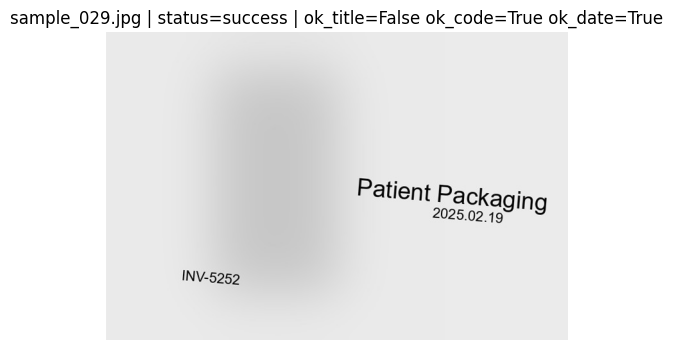

GT  : {'title': 'Patient Packaging', 'code': 'INV-5252', 'date': '2025-02-19'}
PRED: {'title': 'Patient Packagin', 'code': 'INV-5252', 'date': '2025-02-19'}
--------------------------------------------------------------------------------


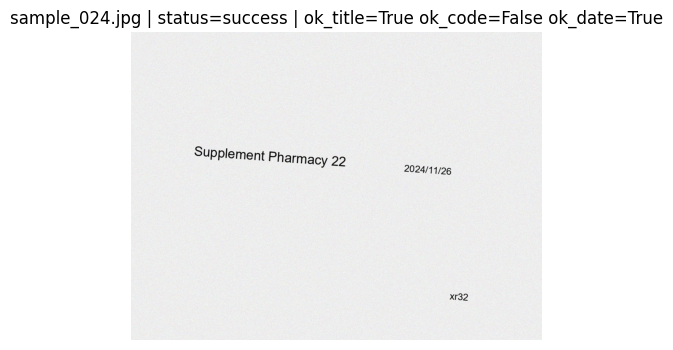

GT  : {'title': 'Supplement Pharmacy 22', 'code': 'xr32', 'date': '2024-11-26'}
PRED: {'title': 'Supplement Pharmacy 22', 'code': 'xr3', 'date': '2024-11-26'}
--------------------------------------------------------------------------------


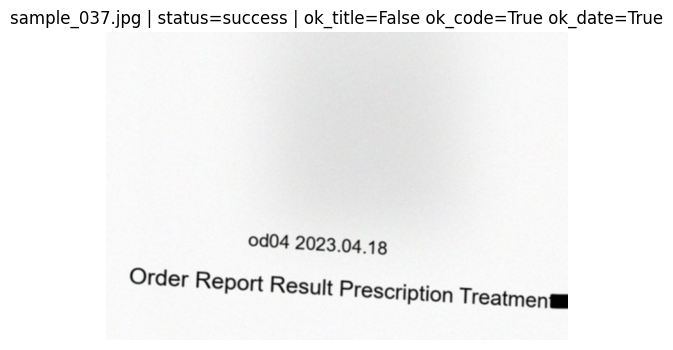

GT  : {'title': 'Order Report Result Prescription Treatment 250', 'code': 'od04', 'date': '2023-04-18'}
PRED: {'title': 'Report Result Prescription T', 'code': 'od04', 'date': '2023-04-18'}
--------------------------------------------------------------------------------


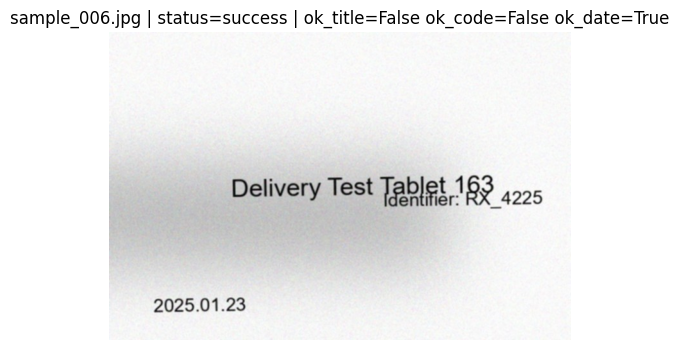

GT  : {'title': 'Delivery Test Tablet 163', 'code': 'RX_4225', 'date': '2025-01-23'}
PRED: {'title': 'Identifier:', 'code': '422', 'date': '2025-01-23'}
--------------------------------------------------------------------------------


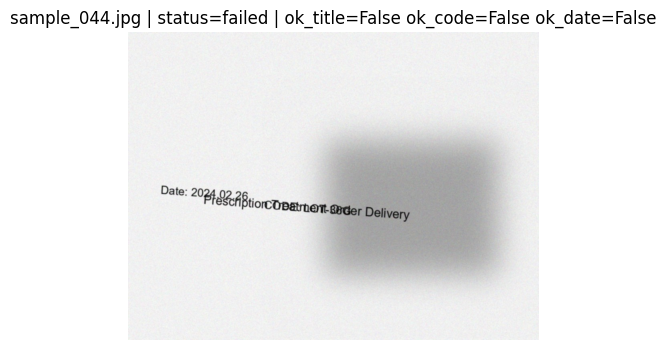

GT  : {'title': 'Prescription Treatment Order Delivery', 'code': 'LOT-36G', 'date': '2024-02-26'}
PRED: {'title': '', 'code': '', 'date': None}
--------------------------------------------------------------------------------


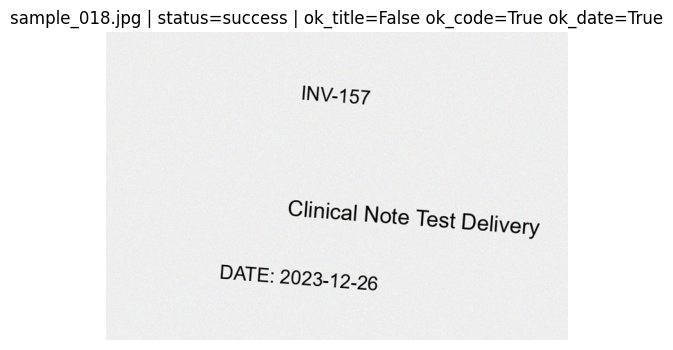

GT  : {'title': 'Clinical Note Test Delivery', 'code': 'INV-157', 'date': '2023-12-26'}
PRED: {'title': 'Clinical Note Test Deliver', 'code': 'INV-157', 'date': '2023-12-26'}
--------------------------------------------------------------------------------


In [27]:
import pandas as pd
import re
from datetime import datetime

GT_CSV = "./samples/ground_truth.csv"
PRED_CSV = "batch_results.csv"
MERGED_CSV = "eval_merged.csv"

DATE_RE = re.compile(r"\b(\d{4}[\/\-.]\d{1,2}[\/\-.]\d{1,2})\b")

def normalize_date_to_iso(s):
    if s is None or (isinstance(s, float) and pd.isna(s)):
        return None
    s = str(s).strip()
    if not s:
        return None

    # extract date substring if it's like "Date: 2025/12/12"
    m = DATE_RE.search(s)
    if m:
        s = m.group(1)

    s2 = s.replace(".", "/").replace("-", "/")
    try:
        dt = datetime.strptime(s2, "%Y/%m/%d")
        return dt.strftime("%Y-%m-%d")
    except ValueError:
        return None

def normalize_text(s):
    if s is None or (isinstance(s, float) and pd.isna(s)):
        return ""
    return str(s).strip()

gt = pd.read_csv(GT_CSV)
pred = pd.read_csv(PRED_CSV)

# normalize GT date and also keep raw gt date
gt["gt_date_iso"] = gt["date"].apply(normalize_date_to_iso)

# normalize predicted strings
pred["pred_title_n"] = pred["pred_title"].apply(normalize_text)
pred["pred_code_n"] = pred["pred_code"].apply(normalize_text)
pred["pred_date_iso"] = pred["pred_date"].apply(normalize_date_to_iso)

gt["gt_title_n"] = gt["title"].apply(normalize_text)
gt["gt_code_n"] = gt["code"].apply(normalize_text)

# merge
df = gt.merge(pred, on="file", how="left")

# success flags
df["ok_status"] = df["status"].eq("success")
df["ok_title"]  = df["pred_title_n"].eq(df["gt_title_n"])
df["ok_code"]   = df["pred_code_n"].eq(df["gt_code_n"])
df["ok_date"]   = df["pred_date_iso"].eq(df["gt_date_iso"])
df["ok_all"]    = df["ok_status"] & df["ok_title"] & df["ok_code"] & df["ok_date"]

# metrics
total = len(df)
success_rate = df["ok_status"].mean()
title_acc = df.loc[df["ok_status"], "ok_title"].mean() if df["ok_status"].any() else 0.0
code_acc  = df.loc[df["ok_status"], "ok_code"].mean()  if df["ok_status"].any() else 0.0
date_acc  = df.loc[df["ok_status"], "ok_date"].mean()  if df["ok_status"].any() else 0.0
all_acc   = df["ok_all"].mean()

print(f"Total images: {total}")
print(f"Status=success rate: {success_rate:.2%}")
print(f"Title accuracy (among success): {title_acc:.2%}")
print(f"Code  accuracy (among success): {code_acc:.2%}")
print(f"Date  accuracy (among success): {date_acc:.2%}")
print(f"ALL fields correct rate: {all_acc:.2%}")

# show top failure cases
fails = df[~df["ok_all"]].copy()

print("\n--- Failure breakdown (first 15 rows) ---")
cols_show = ["file", "status", "error",
             "gt_title_n", "pred_title_n",
             "gt_code_n", "pred_code_n",
             "gt_date_iso", "pred_date_iso",
             "ok_title", "ok_code", "ok_date"]
display(fails[cols_show].head(15))

# save merged file for inspection
df.to_csv(MERGED_CSV, index=False)
print("✅ Saved merged eval CSV:", MERGED_CSV)

# optional: show a few failure images inline
import os
from PIL import Image
import matplotlib.pyplot as plt

def show_fail_examples(n=6):
    if len(fails) == 0:
        print("No failures 🎉")
        return
    sample = fails.sample(min(n, len(fails)), random_state=1)
    for _, r in sample.iterrows():
        path = os.path.join("./samples", r["file"])
        img = Image.open(path)
        plt.figure(figsize=(7,4))
        plt.title(
            f"{r['file']} | status={r['status']} | ok_title={r['ok_title']} ok_code={r['ok_code']} ok_date={r['ok_date']}"
        )
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        print("GT  :", {"title": r["gt_title_n"], "code": r["gt_code_n"], "date": r["gt_date_iso"]})
        print("PRED:", {"title": r["pred_title_n"], "code": r["pred_code_n"], "date": r["pred_date_iso"]})
        print("-"*80)

show_fail_examples(n=6)


In [12]:
DATE_RE = re.compile(r"\b(\d{4}[\/\-.]\d{1,2}[\/\-.]\d{1,2})\b")

def parse_date_to_iso(s: str) -> Optional[str]:
    # try common formats (YYYY/MM/DD, YYYY-MM-DD, YYYY.MM.DD)
    s2 = s.replace(".", "/").replace("-", "/")
    for fmt in ("%Y/%m/%d", "%Y/%d/%m"):  # second is less common; adjust if needed
        try:
            dt = datetime.strptime(s2, fmt)
            return dt.strftime("%Y-%m-%d")
        except ValueError:
            pass
    return None

def score_code_candidate(text: str) -> float:
    t = text.strip()
    if len(t) < 2 or len(t) > 25:
        return -999.0

    # Reject if it looks like a date
    if DATE_RE.search(t):
        return -999.0

    # Must be mostly alnum or separators
    allowed = sum(ch.isalnum() or ch in "-_/" for ch in t)
    ratio = allowed / max(1, len(t))
    if ratio < 0.8:
        return -5.0

    # Bonuses for typical ID patterns
    score = 0.0
    if re.fullmatch(r"[A-Za-z]{1,6}\d{1,6}", t):  # cd01, A1239
        score += 4.0
    if re.fullmatch(r"[A-Za-z0-9]+[-_][A-Za-z0-9]+", t):  # INV-204
        score += 2.0
    if any(ch.isdigit() for ch in t):
        score += 1.0
    if any(ch.isalpha() for ch in t):
        score += 1.0

    # Penalize spaces (IDs usually no spaces)
    if " " in t:
        score -= 2.0

    return score + ratio

def score_title_candidate(text: str) -> float:
    t = text.strip()
    if len(t) < 3:
        return -999.0
    if DATE_RE.search(t):
        return -999.0

    # Basic stats
    letters = sum(ch.isalpha() for ch in t)
    digits = sum(ch.isdigit() for ch in t)
    spaces = sum(ch.isspace() for ch in t)
    alpha_ratio = letters / max(1, len(t))

    # Favor “title-like”: mostly letters, not too many digits, some length
    score = 0.0
    score += alpha_ratio * 5.0
    score += min(len(t) / 10.0, 3.0)          # length bonus (cap)
    score -= digits * 0.3                      # penalize digits
    score += 0.5 if spaces >= 1 else 0.0       # multi-word bonus
    return score

def extract_fields(lines: List[OCRLine]) -> Dict[str, Any]:
    # Keep non-empty lines
    L = [ln for ln in lines if ln.text and ln.text.strip()]
    debug = {"date_candidates": [], "code_candidates": [], "title_candidates": []}

    # ---- DATE ----
    date_best = None
    date_best_score = -1e9
    for ln in L:
        m = DATE_RE.search(ln.text)
        if not m:
            continue
        raw = m.group(1)
        iso = parse_date_to_iso(raw)
        if not iso:
            continue
        score = 10.0 + ln.conf  # strong priority, plus OCR confidence
        debug["date_candidates"].append({"raw": raw, "iso": iso, "line": ln.text, "conf": ln.conf, "score": score})
        if score > date_best_score:
            date_best_score = score
            date_best = {"raw": raw, "iso": iso, "conf": ln.conf, "line_text": ln.text}

    # ---- CODE ----
    code_best = None
    code_best_score = -1e9
    for ln in L:
        s = ln.text.strip()
        sc = score_code_candidate(s)
        score = sc + ln.conf
        debug["code_candidates"].append({"candidate": s, "conf": ln.conf, "score": score})
        if score > code_best_score:
            code_best_score = score
            code_best = {"value": s, "conf": ln.conf, "line_text": ln.text}

    # ---- TITLE ----
    # Exclude date line/code line if they are exact matches
    exclude_texts = set()
    if date_best:
        exclude_texts.add(date_best["line_text"].strip())
    if code_best:
        exclude_texts.add(code_best["line_text"].strip())

    title_best = None
    title_best_score = -1e9
    for ln in L:
        s = ln.text.strip()
        if s in exclude_texts:
            continue
        sc = score_title_candidate(s)
        score = sc + ln.conf
        debug["title_candidates"].append({"candidate": s, "conf": ln.conf, "score": score})
        if score > title_best_score:
            title_best_score = score
            title_best = {"value": s, "conf": ln.conf, "line_text": ln.text}

    # Final checks
    errors = []
    if not title_best:
        errors.append("title not found")
    if not date_best:
        errors.append("date not found")
    if not code_best:
        errors.append("code not found")

    if errors:
        return {
            "status": "failed",
            "error": "Unable to extract required fields: " + ", ".join(errors),
            "debug": debug,
            "raw_lines": [{"text": ln.text, "conf": ln.conf} for ln in L],
        }

    return {
        "status": "success",
        "title": title_best["value"],
        "date": date_best["iso"],
        "code": code_best["value"],
        "confidence": {
            "title": title_best["conf"],
            "date": date_best["conf"],
            "code": code_best["conf"],
        },
        "debug": debug,
        "raw_lines": [{"text": ln.text, "conf": ln.conf} for ln in L],
    }

result = extract_fields(ocr_lines)
print(json.dumps(result, indent=2, ensure_ascii=False))


{
  "status": "success",
  "title": "Test Title",
  "date": "2025-12-12",
  "code": "cd01",
  "confidence": {
    "title": 0.9998038411140442,
    "date": 0.9999787211418152,
    "code": 0.997607946395874
  },
  "debug": {
    "date_candidates": [
      {
        "raw": "2025/12/12",
        "iso": "2025-12-12",
        "line": "2025/12/12",
        "conf": 0.9999787211418152,
        "score": 10.999978721141815
      }
    ],
    "code_candidates": [
      {
        "candidate": "Test Title",
        "conf": 0.9998038411140442,
        "score": 0.8998038411140442
      },
      {
        "candidate": "cd01",
        "conf": 0.997607946395874,
        "score": 7.997607946395874
      },
      {
        "candidate": "2025/12/12",
        "conf": 0.9999787211418152,
        "score": -998.0000212788582
      }
    ],
    "title_candidates": [
      {
        "candidate": "Test Title",
        "conf": 0.9998038411140442,
        "score": 6.999803841114044
      }
    ]
  },
  "raw_lines": 